# Coursework 1
CID: 02455568

# Outline


- [Task 1](#task-1): Linear regression and feature selection <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Non-linear regression with Kernel Ridge Regression <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Classification with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as plt3d

rng = np.random.default_rng(108)

### Data Preprocessing

In this section, I load the data and prepare it. I will split the data into X_train and X_test, as well as y_train and y_test for both the class and the diameter columns. I will standardise X as done in notebooks, using the same standardise function.

In [99]:
train_data = pd.read_csv("data/asteroid_observations_train.csv")
test_data = pd.read_csv("data/asteroid_observations_test.csv")

feature_names = list(train_data.columns[:-2])
print(feature_names)
train_data.head()

['Absolute magnitude', 'Albedo', 'Number of observations', 'Observation arc length', 'Orbital eccentricity', 'Orbital inclination', 'Orbital period']


,Absolute magnitude,Albedo,Number of observations,Observation arc length,Orbital eccentricity,Orbital inclination,Orbital period,Asteroid diameter,Asteroid class
0,18.1,0.041,15,2.0,0.201590,11.975800,3.912298,1.573,MBA
1,12.5,0.139,349,7208.0,0.032746,8.793883,11.942668,12.355,TJN
2,14.1,0.062,705,25309.0,0.179314,27.433960,5.749452,8.862,OMB
3,16.9,0.097,91,3805.0,0.066114,13.813845,4.592982,2.139,MBA
4,11.5,0.062,1300,9606.0,0.008824,5.595907,12.006096,30.763,TJN


In [100]:
# This function is taken from Week 4 tutorial
def standardise(X, X_train_=None):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma

    return X_std


def class_conversion(y_class):
    """
    Convert class labels to integer encoding.

    Parameters:
        y_class (array-like): Array of class labels as strings.

    Returns:
        y_int (np.array): Array of integer-encoded class labels.
    """
    hashmap = {
        "MBA": 0,
        "OMB": 1,
        "TJN": 2
    }
    y_int = np.array([hashmap[y] for y in y_class])
    return y_int


def add_int(X):
    """
    Add an intercept term to the feature matrix.

    Parameters:
        X (np.array): Feature matrix.

    Returns:
        X_aug (np.array): Feature matrix with a leading column of ones.
    """
    N = X.shape[0]
    X_aug = np.hstack([np.ones((N,1)), X])  
    return X_aug


In [101]:
# Convert to numpy
train_arr = train_data.to_numpy()
test_arr = test_data.to_numpy()

# Take only the feature columns
X_train = train_arr[:, :-2].astype(float)

# Diameter column
y_train_diam = train_arr[:, -2].astype(float)
# Class column
y_train_class = train_arr[:, -1].astype(str)
y_train_class_int = class_conversion(y_train_class)

# Split into train and test data
X_test = test_arr[:, :-2]
y_test_diam = test_arr[:, -2].astype(float)
y_test_class = test_arr[:, -1].astype(str)
y_test_class_int = class_conversion(y_test_class)

# Standardise data
X_train_std = standardise(X_train)
X_test_std = standardise(X_test, X_train)




---



<a name="task-1"></a>

# Task 1: Linear regression and feature selection [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

### Garrote feature selection

Garrote aims at learning a linear regression model formulated as follows:

$$
y = f_{\beta^G,\hat{\beta}_0^{LS}}(x) + \epsilon
$$

with

$$
f_{\beta^G,\hat{\beta}_0^{LS}}(x) = x^{T}\beta^{G} + \hat{\beta}_0^{LS}
$$

and

$$
\epsilon \sim \mathcal{N}(0, \sigma^2).
$$

where

$$
x^{T} = (x_1, \ldots, x_p)
$$

is the vector of $p = 7$ data features and $y$ is the regression target (the asteroid’s diameter).  
The Garrote coefficients $(\beta^G)^T = (\beta_1^G, \ldots, \beta_p^G)$ are given by:

$$
\beta_j^G = g_j \hat{\beta}_j^{LS}, 
\qquad j = 1, \ldots, p, 
\qquad g_j \in \mathbb{R}.
$$

where

$$
(\hat{\beta}^{LS})^{T} = 
(\hat{\beta}_0^{LS}, \hat{\beta}_1^{LS}, \ldots, \hat{\beta}_p^{LS})
$$

are the ordinary least-squares parameter estimates for the linear regression function modelling the relationship between $x$ and $y$.  
The Garrote parameters $g = (g_1, \ldots, g_p)$ are learnt by minimising the mean squared error (MSE) over the training set:

$$
\min_{g}
\left[
\frac{1}{N^{\text{train}}}
\sum_{i=1}^{N^{\text{train}}}
\left(
y^{(i)} - f_{\beta^G,\hat{\beta}_0^{LS}}\big(x^{(i)}\big)
\right)^2
\right].
$$

with the constraint $||\boldsymbol{g}||_1 < s$ for some $s \in \mathbf{R}_{\geq}0$

Here one replaces $||\boldsymbol{g}||_1$ with the Huber Loss $\sum_{i=1}^p L_c(g_i)$, where $L_c(g_i)$ is defined as:

$L_c (g_i) =
\begin{cases}
 \frac{1}{2}{g^2_i}                   & \text{for } |g_i| \le c, \\
 c (|g_i| - \frac{1}{2}c), & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

The $c$ parameter in Huber determines the range around zero with $L_2$-like behaviour to ensure smoothness and, hence, better convergence.

The piecewise smooth function $L_c (g_i)$ has the gradient:

$\frac{dL_c (g_i)}{dg_i} =
  \begin{cases}
 g_i                   & \text{for } |g_i| \le c, \\
 c\, \text{sign}(g_i) , & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

Now we can minimise the following relaxed function by gradient descent:

$$
\min_{g \in \mathbb{R}^p}
\frac{1}{N}
\sum_{i=1}^{N}
\left(
y^{(i)} - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
\quad
\text{subject to}
\quad
\sum_{j=1}^{p} |g_j| \le s
$$
Which is equivalent to
$$
\min_{g \in \mathbb{R}^p}
\left\{
\frac{1}{2}
\sum_{i=1}^{N}
\left(
y_i - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
+
\lambda
\sum_{j=1}^{p} |g_j|
\right\}
$$

To compute the gradient we use the fact that 
$ \nabla_{\beta} || y - X\beta|| = -2X^{\top}(y - X\beta)$

Applying this and chain rule to the expression we're minimising gives:

$$
\nabla_g || y - \mathbf{1}\beta_0 - X(g \odot \beta) || = \beta \odot [- 2X^{\top}(y- \mathbf{1}\beta_0 - X(g \odot \beta))]
$$

We proceed with gradient descent, that is, updating the value of $g_{n+1} = g_n - \eta \nabla_g$, where $\eta$ is the step size (a constant hyperparameter).

In [102]:
N, p = X_train_std.shape
X_aug = add_int(X_train_std) # augmented training inputs of size N x (p+1)

In [103]:
# These functions are taken from Week1 Tutorial

def max_lik_estimate(X, y):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (p x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    beta_ml = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_ml

def max_lik_estimate_aug(X_aug, y):

    beta_aug_ml = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y

    return beta_aug_ml

# huber loss
def huber(beta, c = 1e-4):
    return np.where(np.abs(beta) < c, (beta**2)/2.,c * (np.abs(beta) - c/2))

# gradient of huber loss
def grad_huber(beta, c = 1e-4):
    g = np.empty_like(beta)
    return  np.where(np.abs(beta) < c, beta, c * np.sign(beta))

In [104]:
def minimise_g(x, y, beta_ls_with_int, lam, n_iters=10**4, step_size=1e-7, c_huber=1e-4):
    """
    Minimise the Garrote scaling parameters using gradient descent.

    Parameters:
        x (np.array): Design matrix of shape (N, p).
        y (np.array): Target vector of length N.
        beta_ls_with_int (np.array): Vector of least squares estimates of length p+1,
            including the intercept term.
        lam (float): Regularisation parameter.
        n_iters (int): Number of gradient descent iterations.
        step_size (float): Learning rate for gradient descent.
        c_huber (float): Parameter for the Huber regularisation term.

    Returns:
        beta_g (np.array): Estimated Garrote coefficients (scaled LS coefficients).
    """

    # Split beta into the intercept term and the rest (p terms)
    N = len(y)
    beta_ls = beta_ls_with_int[1::]
    beta0 = beta_ls_with_int[0]

    # Initialise g
    g = np.zeros(len(beta_ls))

    # Gradient descent to minimise g
    for i in range(n_iters):
        # Compute the gradient of Huber function
        grad_c = grad_huber(g, c=c_huber)

        # Compute the gradient of the regularised loss.
        grad = beta_ls * (-2 * x.T @ (y - beta0 - x @ (beta_ls * g))) / N + lam * grad_c

        # Update beta
        g -= step_size * grad 

    return g * beta_ls


def fit_garrote(x, beta_g, beta_ls_with_int):
    beta0 = beta_ls_with_int[0]
    y = x @ beta_g + beta0
    return y


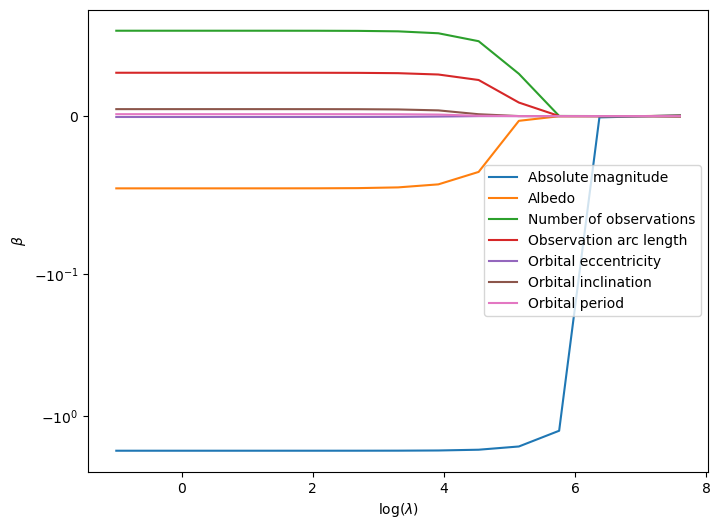

In [105]:
# Initialise the array of lambdas
lambdas = np.logspace(-1, 7.6, 15)
log_lambdas = np.log10(lambdas)

# Fit the model for different lambdas
X_aug = add_int(X_train_std) # augmented training inputs of size N x (p+1)
beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train_diam)

beta_paths = np.vstack([
    minimise_g(X_train_std, y_train_diam, beta_ls_with_int, lam)
    for lam in lambdas
])

# Plot results
plt.figure(figsize=(8, 6))
for j, fn in enumerate(feature_names):
    plt.plot(log_lambdas, beta_paths[:, j], label=fn)

plt.xlabel(r"$\log(\lambda)$")
plt.ylabel(r"$\beta$")
plt.yscale("symlog",linthresh=0.1)
plt.legend()
plt.show()


The graph shows that as lambda becomes too large, all coefficients converge to 0 - as expected. As lambda increases, the 
$\lambda \sum_{j=1}^{p} |g_j|$ term starts to dominate the minimisation up to a point where our algorithm just minimises this part, making all gs equal to 0.

The absolute magnitude converges to 0 last, and it has the biggest weight in absolute value, implying that this is one of the strongest predictors for the diameter. Albeido is another strong predictor. On the other hand, Orbital period, Orbital eccentricity and Orbital inclination are all very close to 0 for all $\lambda$, suggesting they do not hold a lot of predictive power. 

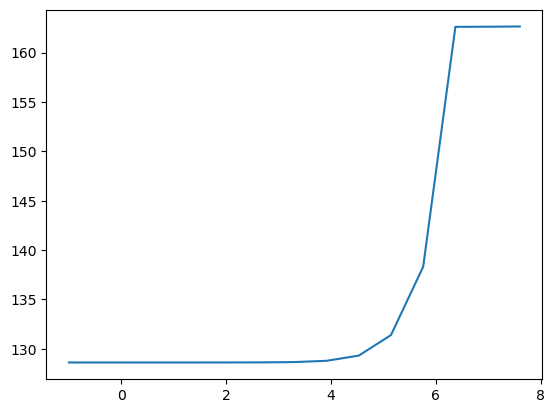

In [106]:
def MSE_garotte(X_train, y_train, X_val, y_val, lam):
    """
    Compute the mean squared error (MSE) of the Garrote model.

    Parameters:
        X_train (np.array): Training feature matrix of shape (N_train, p).
        y_train (np.array): Training target vector of length N_train.
        X_val (np.array): Validation feature matrix of shape (N_val, p).
        y_val (np.array): Validation target vector of length N_val.
        lam (float): Regularisation parameter for the Garrote model.

    Returns:
        MSE (float): Mean squared error on the validation set.
    """

    # Predict fitted values y_hat
    X_aug = add_int(X_train)  # augmented training inputs of size N x (p+1)
    beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train)
    beta_g = minimise_g(X_train, y_train, beta_ls_with_int, lam)
    y_hat = fit_garrote(X_val, beta_g, beta_ls_with_int)

    # Compute MSE
    MSE = np.mean((y_hat - y_val)**2)

    return MSE


# Out of curiosity, let's plot MSE for different values of lambda    
MSEs = np.array([ MSE_garotte(X_train_std, y_train_diam, X_test_std, y_test_diam, lam) for lam in lambdas])
min_lam = np.argmin(MSEs)

plt.figure()
plt.plot(log_lambdas, MSEs)


The graph above shows the MSE of the predictions of the test data plotted against different values of $\log(\lambda)$. It stays more or less the same for most values of $\lambda$ until it start to increase steeply. There is a clear cutoff at around 6, where the MSE becomes much larger, meaning that $\lambda$ is now too big. This means that a reasonable choice of lambda is anywhere within [-1, 5].

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

### Assessing stability via T-fold cross-validation

To assess the
effect on Garrote’s performance of changes in the training data I will perform T-fold cross-validation by splitting training data into T folds, for T = 2, 20 (without reshuffling the data before dividing them into folds):

1. Train Garrote, using the same hyperparameters as in Task 1.1.

2. Compute the average validation MSE, $MSE_t$, for all folds $t = 1, \ldots, T$ (see Chapter 2 of the Lecture Notes).

3. Compute the average absolute difference in the validation MSE between successive folds $D$:

$$
D = \frac{1}{T - 1} \sum_{t=2}^{T} \left| MSE_t - MSE_{t-1} \right|.
$$



In [107]:
def D(full_X, full_y, T, lam):
    """
Compute the average absolute difference in validation MSE across T folds.

Parameters:
    full_X (np.array): Full feature matrix of shape (N, p).
    full_y (np.array): Full target vector of length N.
    T (int): Number of folds for cross-validation.
    lam (float): Regularisation parameter for the Garrote model.

Returns:
    D (float): Average absolute difference between successive
        validation MSE values across folds.
"""

    # Find the length of a fold
    N = len(full_y)
    fold_size = N // T

    # Initialise list to store MSE for each fold
    MSEs = []

    # Loop over folds
    for t in range(T):
        # Boolean mask to separate train / val indices
        val_mask = np.zeros(N, dtype=bool)
        val_mask[t*fold_size:(t+1)*fold_size] = True

        # Apply mask
        X_val_not_std = full_X[val_mask]
        X_train_not_std = full_X[~val_mask]
        y_train = full_y[~val_mask]
        y_val = full_y[val_mask]

        # Standardise validation first and then training set
        # To prevent data leakage
        X_val = standardise(X_val_not_std, X_train_= X_train_not_std)
        X_train = standardise(X_train_not_std)

        # Calculate MSE of the fold and add to list
        MSEs.append(MSE_garotte(X_train, y_train, X_val, y_val, lam))
    
    # Find average absolute difference
    D = np.mean(np.abs(np.diff(np.array(MSEs))))

    return D

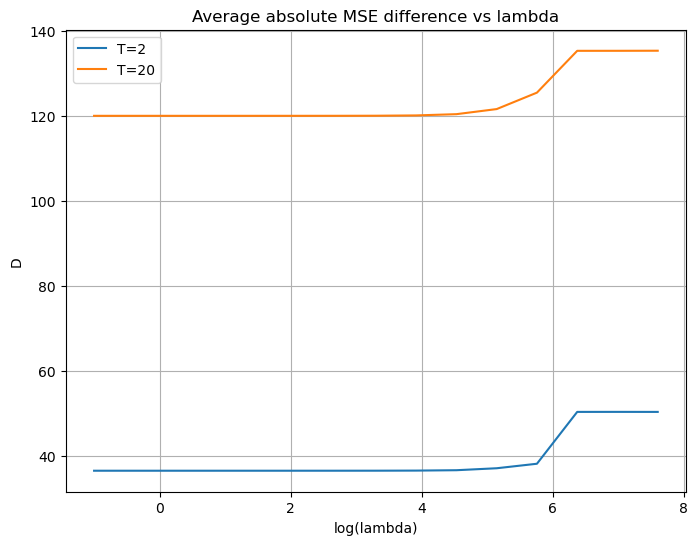

In [108]:
Ts = [2, 20]
Ds = []


for T in Ts:
    Ds.append([])
    for lam in lambdas:
        Ds[-1].append(D(X_train, y_train_diam, T, lam))

plt.figure(figsize=(8,6))
plt.plot(log_lambdas, Ds[0], label="T=2")
plt.plot(log_lambdas, Ds[1], label="T=20")

plt.xlabel("log(lambda)")
plt.ylabel("D")
plt.title("Average absolute MSE difference vs lambda")
plt.legend()
plt.grid(True)

plt.show()


The graph suggests that D eventually increases with λ, particularly for large values of λ. This indicates that strong regularisation leads to greater instability in validation performance, which is consistent with the results of 1.1, where we clearly saw that after lambda goes past 6, the quality of the model decreases.

Furthermore, the instability measure D is significantly larger for T=20 than for T=2, which might be caused by the increased variability introduced by smaller validation folds. This is due to the fact that for T=2, the validation set is large (half of the data), hence MSE is averaged over many points and so it is natuarally mose stable. For T = 20, since successive training sets differ only slightly, D is even more sensitive to small perturbations in the data.

On the other hand, we know that increasing T decreases the bias of the predictor, so there is a trade-off between stability and bias here. 

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)
### Assessing LASSO feature selection stability via bootstrap

First, let's perform Lasso regression with the Huber function-based smoothing and compare results to 1.1. Here, I will use the same setup and same functions as in Week 1 notebook.

In [109]:
# From week 1 notebook
def minimize_ls_huber(X, y, lambd, n_iters = 10000, step_size=5e-5, c_huber=1e-4):
    """
    This function estimates the regression parameters with the relaxed version
    of LASSO regression using the gradient-descent algorithm to find the optimal
    solution.
    Args:
    X (np.array): The augmented data matrix with shape (N, p + 1).
    y (np.array): The response column with shape (N, 1).
    lambd (float): The multiplier of the relaxed L1 term.
    n_iters (int): Number of gradient descent iterations.
    step_size (float): The step size in the updating step.
    """

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    # Precomputed products to avoid redundant computations.
    XX = X.T @ X
    Xy = X.T @ y
    # Initialize beta params with zeros
    beta = np.zeros(p)

    for i in range(n_iters):
        # Compute the gradient of the relaxed LASSO, Huber.
        grad_c = grad_huber(beta, c=c_huber)

        # Intercept term is not involved in the regularisation.
        grad_c[0] = 0 ## <-- EDIT THIS LINE

        # Compute the gradient of the regularised loss.
        grad =  2 * (XX @ beta - Xy) / N + lambd * grad_c ## <-- EDIT THIS LINE

        # Update beta
        beta -= step_size * grad ## <-- EDIT THIS LINE

    return beta

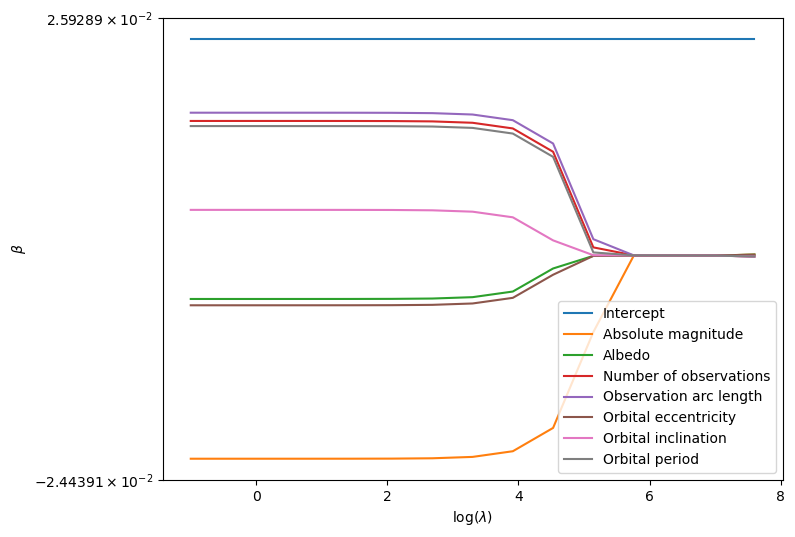

In [110]:
# Run LASSO regression for different lambdas

lasso_paths = np.vstack([
    minimize_ls_huber(X_aug, y_train_diam, lam, n_iters=10000,
                                step_size=1e-7,
                                c_huber=1e-4)
    for lam in lambdas
])

feature_names_with_int = ["Intercept"] + feature_names

#Plot results
plt.figure(figsize=(8, 6))
for j, fn in enumerate(feature_names_with_int):
    plt.plot(log_lambdas, lasso_paths[:, j], label=fn)

plt.xlabel(r"$\log(\lambda)$")
plt.ylabel(r"$\beta$")
plt.yscale("symlog",linthresh=0.1)
plt.legend()
plt.show()


The graph is similar to 1.1 in the sense that we also see all coefficients eventually going to zero, as lambda increases and the regularisation term starts dominating over least squares. The main difference is that the coefficients converge faster, implying that lambda has more weight here compared to Garotte. The predictors are consistent with 1.1 as well, with absolute magnitude being the biggest negative predictor, Albeido also being negative, but weaker in both.

Next, I use the following bootstrap-based procedure to compute the selection probability of the different data
features. For a given $\lambda$:
1. Resample without replacement B = 100 bootstrap samples of size N′ from the training dataset.
2. For each bootstrap sample, train a LASSO regressor as described above and decide which features are selected by it (consider a feature selected if it has an associated coefficient > 0.001 in absolute value).
3. For each feature, compute its selection probability as the fraction of bootstrap samples where that feature was selected through LASSO.

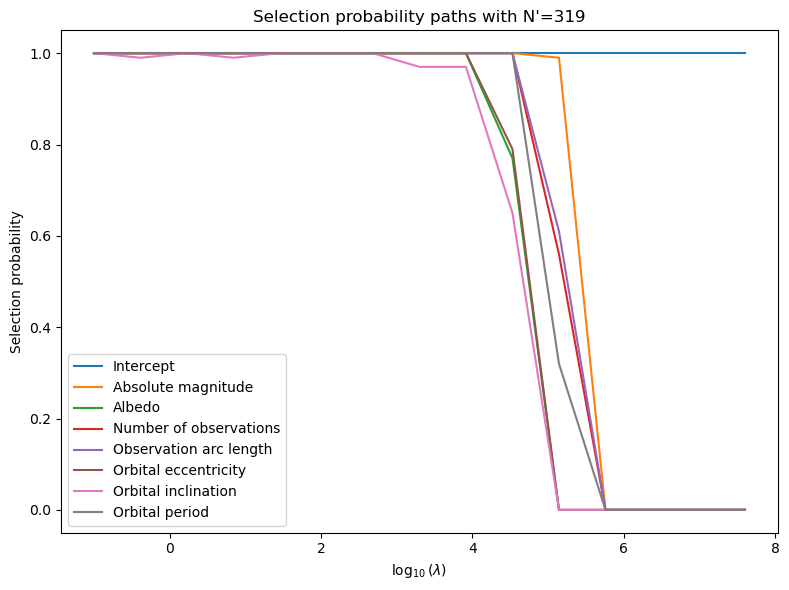

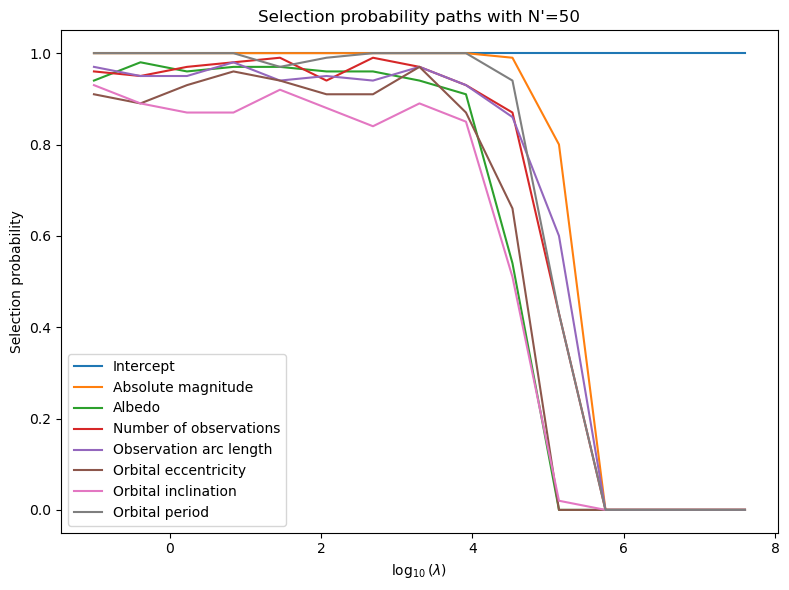

In [111]:
B = 100
N_dashes = [len(X_train_std) // 2, 50]
n = X_aug.shape[0]

# This list will contain two lists of probability paths
# for the two differen N_dashes 
prob_paths_Ns = []

for N_dash in N_dashes:
    # Initialise a list of probability paths
    prob_paths = []
    for lam in lambdas:
        
        # This will be a list of feauters_selected arrays
        # Which we will average over to find selection probabilities
        features_bootstrap = []

        # Perform B bootstrap subsamples
        for i in range(B):

            # Randomly select N_dash samples without replacement
            idx = rng.choice(n, size=N_dash, replace=False)

            # Create subsample dataset
            X_sample = X_aug[idx]
            y_sample = y_train_diam[idx]

            # Fit Lasso
            beta_lasso = minimize_ls_huber(X_sample, y_sample, lam, n_iters=10000,
                                        step_size=1e-7,
                                        c_huber=1e-4)
            # Decide wether feature was selected (if coef is > 0.001)
            # Store 1 if feature was selected, 0 otherwise
            feauters_selected = np.where(np.abs(beta_lasso) > 0.001, 1, 0)
            features_bootstrap.append(feauters_selected)

        # Average over feauters_selected array
        # to compute selection probabilities
        # as a proportion of times a feature was selected
        feature_probabilities = np.array(features_bootstrap).mean(axis=0)

        # Add to probability paths
        prob_paths.append(feature_probabilities)
    prob_paths_Ns.append(prob_paths)

    prob_paths = np.array(prob_paths)  # (n_lambdas, n_features)

    # Plot results
    plt.figure(figsize=(8, 6))

    for j, name in enumerate(feature_names_with_int):
        plt.plot(
            log_lambdas,
            prob_paths[:, j],
            label=name
        )

    plt.xlabel(r"$\log_{10}(\lambda)$")
    plt.ylabel("Selection probability")
    plt.title(f"Selection probability paths with N'={N_dash}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Selection probability is the proportion of times our algorithm decided to include a feature (by not setting it's corresponding g value to 0, or almost zero - we use the threshold of 1e-3) in the regression - i.e. select it. In terms of feature selection stability, the selection probability tells us if a feature will still be selected if we perturb the data a little - features that were selected the most regardless of which bootstrap sample was used are more stable therefore.

Probability trajectories show, once again, that for large values of $\lambda$ all the features will end up not being selected. The steep change, once again, happenes at around $\lambda = 5$, as we have seen in 1.1. These results also suggest that Absolute magnitude is the most stable feature, since it's probability goes to 0 last, while Orbital inclination goes to 0 first, meaning it is the least stable, which is consistent with previous results.

For the small N' = 50, we see that the trajectories oscillate more, which can be explained by the fact that the bootstrap samples are smaller in size and hence differ from each other more, increasing the variance. Ultimately, both cases lead to the same conclusion: as the value of lambda reaches aorund 5, features stop being selected due to regularisation term being too strong. Apart from that, this way of deciding which features are more stable or important doesn't give clear results, as most features have selection probabilities near 1.

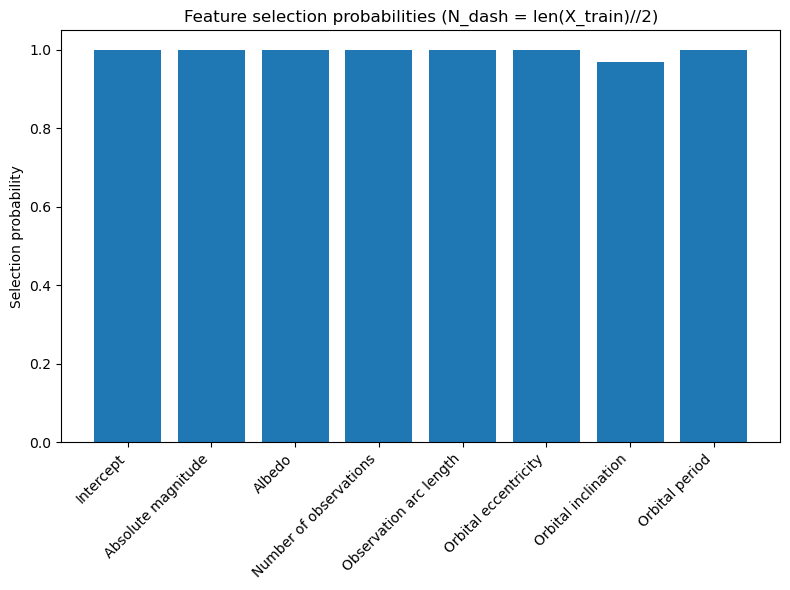

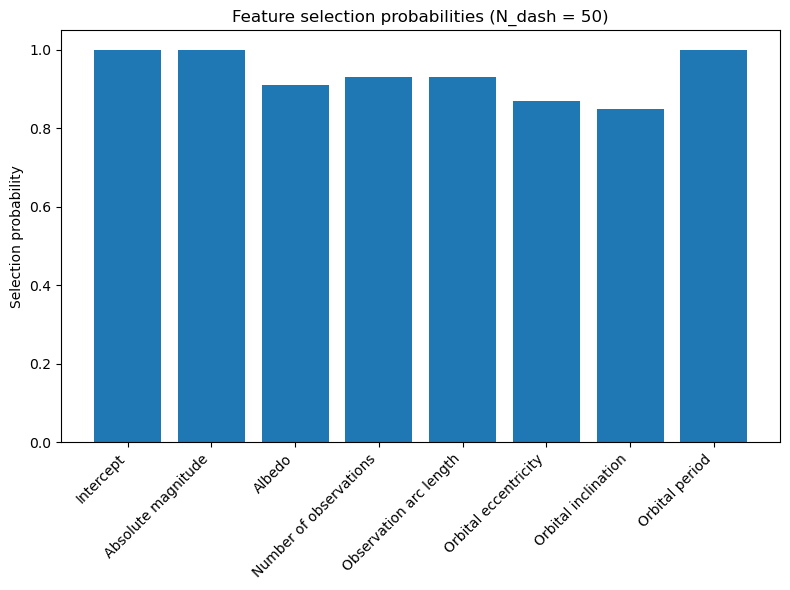

In [126]:
# Now we fix the value of lambda and produce bar plots
#  of selection probabilities
idx = 8
probs_arr = np.array(prob_paths_Ns)
probs_last_lambda = probs_arr[:, idx, :]

# First N_dash
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(feature_names_with_int)), probs_last_lambda[0])
plt.xticks(np.arange(len(feature_names_with_int)), feature_names_with_int, rotation=45, ha="right")
plt.ylabel("Selection probability")
plt.title("Feature selection probabilities (N_dash = len(X_train)//2)")
plt.tight_layout()
plt.show()

# Second N_dash
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(feature_names_with_int)), probs_last_lambda[1])
plt.xticks(np.arange(len(feature_names_with_int)), feature_names_with_int, rotation=45, ha="right")
plt.ylabel("Selection probability")
plt.title("Feature selection probabilities (N_dash = 50)")
plt.tight_layout()
plt.show()


The barchart draws a similar picture to the graphs above, in the sense that this method of choosing more important features, does not yield clear results. For N'= len(X_train) / 2 all but one features are selected with probability 1. N' = 50 case suggests that Orbital Inclination and Orbital eccentricity are less selected than other features, which is consistent with Garrote feature selection, where the coefficients of these predictors were close or equal to 0 across all values of $\lambda$.

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

In this section I train an ordinary linear regressor on the training data and estimate the relative importance of each feature through the method of variable importance explained in Chapter 5 of the Lecture Notes, use the test set in place of the out-of-bag samples and the R2 score as metric of performance, and produce a bar plot of variable importance for all features, expressing it as a percentage of the importance of the most important feature.

In [127]:
def r_squared(y_hat, y):
    """
    Compute the coefficient of determination (R^2).

    Parameters:
        y_hat (np.array): Predicted target values.
        y (np.array): True target values.

    Returns:
        r2 (float): R-squared score.
    """
    return 1 - np.sum((y_hat - y)**2) / np.sum((y - np.mean(y))**2)


def train_regression(X_train, y_train):
    """
    Train a linear regression model using maximum likelihood estimation.

    Parameters:
        X_train (np.array): Training feature matrix of shape (N, p).
        y_train (np.array): Training target vector of length N.

    Returns:
        betas (np.array): Estimated regression coefficients including intercept.
    """
    X_train_aug = add_int(X_train)
    betas = max_lik_estimate(X_train_aug, y_train)
    return betas


def importance(X_test, y_test, feature, betas):
    """
    Compute permutation feature importance based on change in R^2.

    Parameters:
        X_test (np.array): Test feature matrix of shape (N, p).
        y_test (np.array): Test target vector of length N.
        feature (int): Index of feature to permute.
        betas (np.array): Regression coefficients including intercept.

    Returns:
        importance (float): Absolute change in R^2 after permutation.
    """
    X_test_aug = add_int(X_test)

    # Baseline performance
    y_hat_baseline = X_test_aug @ betas
    r_squared_baseline = r_squared(y_hat_baseline, y_test)

    # Permute selected feature
    X_perm = X_test_aug.copy()
    X_perm[:, feature] = rng.permutation(X_perm[:, feature])

    # Performance after permutation
    y_hat_perm = X_perm @ betas
    r_squared_perm = r_squared(y_hat_perm, y_test)

    return np.abs(r_squared_baseline - r_squared_perm)
 



<a name="task-2"></a>

# Task 2: Non-linear regression with Kernel Ridge Regression [(index)](#index-task-2)

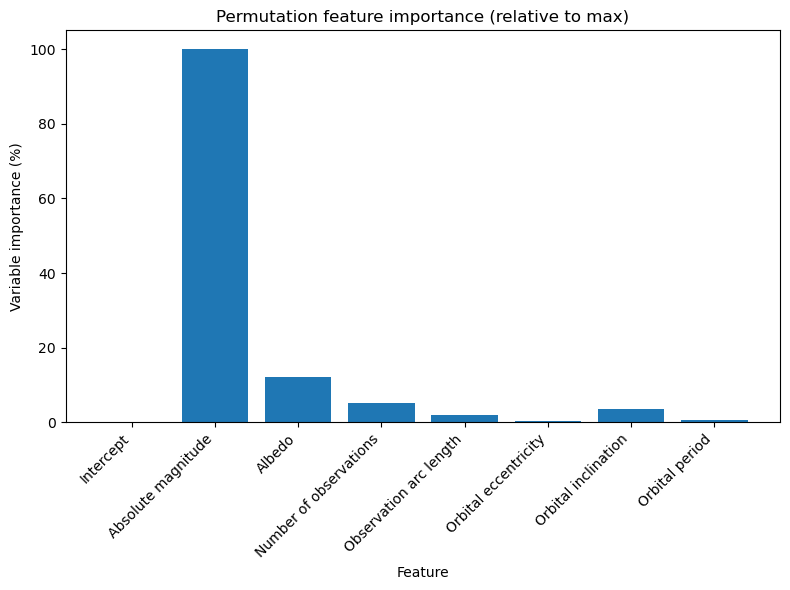

In [128]:
# Train Ordinary Least Squares regression on training data
ols_betas = train_regression(X_train_std, y_train_diam)

# Number of features (with intercept)
p_int = X_test_std.shape[1] + 1

# Compute importance for each feature
feature_imp = np.array([
    importance(X_test_std, y_test_diam, feature, ols_betas)
    for feature in range(p_int)
])

# Convert to percentage of the most important feature
feature_imp_pct = 100 * feature_imp / np.max(feature_imp)

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(np.arange(p_int), feature_imp_pct)
plt.xticks(np.arange(p_int), feature_names_with_int, rotation=45, ha="right")
plt.ylabel("Variable importance (%)")
plt.xlabel("Feature")
plt.title("Permutation feature importance (relative to max)")
plt.tight_layout()
plt.show()


This chart clearly shows that Absolute Magnitude is by far the most important feature, shich is consistent to the results of 1.1 - ABsolute magnitude was also shown to be a strong and stable predictor. The interpretation of importance is that permuting the absolute magnitude column changes the $R^2$ the most, meaning it is an important predictor. Second most important feature is Albedo which is again consistent with previous parts. 

All in all, this method of identifying more important features is a lot more decisive than the selection probabilities from 1.3, where there wasn't a clear distinction between different features.

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In [129]:
# From Week 2 notebook
def ridge_estimate(X, y, penalty):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters ((p + 1) x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    X_aug = add_int(X) # augmented training inputs of size N x (p + 1)
    N_aug, p_aug = X_aug.shape
    I = np.identity(p_aug)
    I[0] = 0.0 # penalty excludes the bias term.
    beta_ridge = np.linalg.inv(X_aug.T @ X_aug + penalty * np.eye(p_aug)) @ X_aug.T @ y
    return beta_ridge

def fit_ridge(X_train, y_train, penalty, X_test):
    X_test_aug = add_int(X_test)
    betas = ridge_estimate(X_train, y_train, penalty)
    y_hat = X_test_aug @ betas
    return y_hat



y_fitted_train = fit_ridge(X_train_std, y_train_diam, 0.1, X_train_std)
y_fitted_test = fit_ridge(X_train_std, y_train_diam, 0.1, X_test_std)
print(r_squared(y_fitted_train, y_train_diam), r_squared(y_fitted_test, y_test_diam))

0.756284223512813 0.7363169499385698


Regular Ridge Regression yields $R^2 = 0.74$ for the test data, which is a good, albeit not outstanding performance. The advantage of this model is that it is very simple, interpretable and computationally inexpensive, and there is usually a trade-off between such simplicity and performance. Let's see if kernelising to add non-linearity in the model will improve it's performance.

### Kernalised Ridge Regression.

We use $$ k^{p}(v, z) = (v \cdot z + c)^{n} $$ as our kernel.

From lecture notes we know that $$ k(v, z) = \phi(v) \cdot \phi(z) $$

So we are trying to minimise the following loss function:

$$
L(\beta)
=
\frac{1}{N}
\sum_{i=1}^{N}
\left(
y^{(i)} - \phi(x^{(i)})^{\top} \beta
\right)^2
+ \lambda \lVert \beta \rVert^2
$$

Define $\beta_k$ s. t. $\beta = \sum_{i=1}^{N} \phi(x^i)\beta_k^i $

Then the regularisation term becomes

$$
 \lVert \beta \rVert^2 = \beta \cdot \beta = \beta_k^{\top} K \beta_k = \lVert \beta_k \rVert^2_K
$$
Where $ K_{ij} = k^p(x_i, x_j)$, where $x_i, x_j$ are rows of the data metrix X

And since $ k(x_i, x_j) = \phi(x_i) \cdot \phi(x_j) $, the loss function becomes

$$
\mathcal{L}(\beta_k)
= \frac{1}{n}\,\|y - K\beta_k\|^2 + \lambda\, \beta_k^{\top} K \beta_k
$$

$$
\nabla \mathcal{L}(\beta_k)
= \frac{2}{n_{train}}\bigl(K^{\top}K\beta_k - K^{\top}y\bigr) + 2\lambda K\beta_k = 0
$$

$$
\hat{\beta}_k
= \left(K^{\top}K + \lambda n_{train} K\right)^{-1} K^{\top} y
$$

$$
= \left(K^{2} + n_{train}\lambda K\right)^{-1} K y
$$

$$
= \left(K + n_{train}\lambda I\right)^{-1} y,
$$
$$
\text{since } K = K^{\top}.
$$

Now, let's make predictions:
$$
\hat{y} = K\beta_k
$$



In [130]:
def Gram(x, y, c=1, n=3):
    """
        x (np.array): First input matrix of shape (N, p).
        y (np.array): Second input matrix of shape (M, p).

    Returns:
        K (np.array): Gram matrix of shape (N, M).
    """
    return (x @ y.T + c) ** n


def beta_krr(X_train, y_train, lam, K):
    """
    Compute dual coefficients for Kernel Ridge Regression.

    Parameters:
        X_train (np.array): Training feature matrix of shape (N, p).
        y_train (np.array): Training target vector of length N.
        lam (float): Regularisation parameter.
        K (np.array): Gram matrix of shape (N, N).

    Returns:
        betas (np.array): Vector of coefficients of length N.
    """
    n_train = X_train.shape[0]
    betas = np.linalg.inv(K + n_train * lam * np.eye(n_train)) @ y_train
    return betas

    

In [131]:

def performance_n_c(X_train, y_train, X_test, y_test, n, c):
    """
    Evaluate Kernel Ridge Regression performance for a polynomial kernel
    with given degree and constant.

    Parameters:
        X_train (np.array): Training feature matrix of shape (N_train, p).
        y_train (np.array): Training target vector of length N_train.
        X_test (np.array): Test feature matrix of shape (N_test, p).
        y_test (np.array): Test target vector of length N_test.
        n (int): Degree of the polynomial kernel.
        c (float): Constant term of the polynomial kernel.

    Returns:
        Prints training and test R^2 scores.
    """
    # COmpute K for training and testing, as well as optimal betas
    K_train = Gram(X_train, X_train, c, n)
    K_test = Gram(X_test, X_train, c, n)

    betas_k = beta_krr(X_train, y_train, 0.1, K_train)

    # Obtain r^2 scores
    r_squared_train = r_squared(K_train @ betas_k, y_train)
    r_squared_test = r_squared(K_test @ betas_k, y_test)

    print(f"n = {n}, c = {c}: Train R^2 = {r_squared_train}, Test R^2 = {r_squared_test}")

performance_n_c(X_train_std, y_train_diam, X_test_std, y_test_diam, 2, 0)
performance_n_c(X_train_std, y_train_diam, X_test_std, y_test_diam, 2, 1)
performance_n_c(X_train_std, y_train_diam, X_test_std, y_test_diam, 3, 1)

n = 2, c = 0: Train R^2 = 0.744277295023313, Test R^2 = 0.6175788574986535
n = 2, c = 1: Train R^2 = 0.953255587713263, Test R^2 = 0.947743591512433
n = 3, c = 1: Train R^2 = 0.9843306895540649, Test R^2 = 0.975992926426917


Results show that the cubic kernel performs the best for both training and test data. The quadratic kernel with c = 1 also performs very well with $R^2 > 0.9$. The quadratic kernel with c = 0 performs significantly worse. 

Overall, adding a kernel significantly improved the results compared with regular ridge regression, suggesting that the relationship between the predictors and the diameter is in fact non-linear. We will nowexplore other kernels to try to fiind the optimal non-linear setup.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

### Fitting power of kernels

In this task, we will consider as inputs the reduced data vector 
$$
\bar{x} =
\begin{pmatrix}
x_1 \\
x_2
\end{pmatrix}.
$$

We compare three different kernel choices:

**1. Polynomial kernel**

$$
k^{P}(v, z) = (v \cdot z + 1)^2,
$$

with degree $n = 2$ and $c = 1$.

**2. Radial Basis Function (RBF) kernel**

For two vectors $v$ and $z$,

$$
k^{RBF}(v, z) = \exp\left(-\frac{\|v - z\|^2}{\sigma}\right).
$$

**3. New kernel**

We construct a new kernel starting from $k^{P}$ and $k^{RBF}$:

$$
k^{new}(v, z) = k^{RBF}\big(\phi^{P}(v), \phi^{P}(z)\big),
$$

where $\phi^{P}(v)$ is the feature transformation associated with the polynomial kernel $k^{P}$ defined above. In particular,

$$
\phi^{P}(v) \cdot \phi^{P}(z) = (v \cdot z + 1)^2.
$$

In practice, we don't know $\phi$, so we can rewrite:
$$
k^{new}(v, z) = \exp\left(-\frac{\|\phi^{P}(v) - \phi^{P}(z)\|^2}{\sigma}\right), \text{where}
$$
$$
\|\phi^{P}(v) - \phi^{P}(z)\|^2 = \phi^{P}(v) \cdot \phi^{P}(v) - 2 \phi^{P}(v) \cdot \phi^{P}(z) + \phi^{P}(z) \cdot \phi^{P}(z) = k^{P}(v, v) - 2 k^{P}(v, z) + k^{P}(z, z)
$$


In [132]:
def poly_kernel(x, y):
    return (x @ y.T + 1)**2

def radial_kernel(x, y, sigma=20):
    x_sq = np.sum(x**2, axis=1)[:, None]   # (n_x, 1)
    y_sq = np.sum(y**2, axis=1)[None, :]   # (1, n_y)
    return np.exp(-(x_sq - 2.0 * (x @ y.T) + y_sq) / sigma)

def new_kernel(x, y, sigma=20):
    Kxy = poly_kernel(x, y)  # (n_x, n_y)

    # Diagonal terms k(x_i, x_i) and k(y_j, y_j)
    xx_diag = np.diag(poly_kernel(x, x))  # (n_x,)
    yy_diag = np.diag(poly_kernel(y, y))  # (n_y,)

    # Squared distances in feature space
    D = xx_diag[:, None] - 2.0 * Kxy + yy_diag[None, :]
    return np.exp(- D / sigma)

kernel_dict = {poly_kernel: "Quadratic Kernel",
               radial_kernel: "Radial Kernel",
               new_kernel: "Mixed Kernel",
               Gram: "Polynomial Kernel"}

def kernel_performance(kernel, X_train, y_train, lam):
    gram = kernel(X_train, X_train)
    betas = beta_krr(X_train, y_train, lam, gram)
    r_sqr = r_squared(gram @ betas, y_train)
    print(f"{kernel_dict[kernel]} R^2: {r_sqr}")

In [133]:
X_reduced = X_train_std[:, :2]

lam = 300

print(f"Lambda = {lam}")
kernel_performance(poly_kernel, X_reduced, y_train_diam, lam)
kernel_performance(radial_kernel, X_reduced, y_train_diam, lam)
kernel_performance(new_kernel, X_reduced, y_train_diam, lam)

lam = 0.1

print(f"Lambda = {lam}")
kernel_performance(poly_kernel, X_reduced, y_train_diam, lam)
kernel_performance(radial_kernel, X_reduced, y_train_diam, lam)
kernel_performance(new_kernel, X_reduced, y_train_diam, lam)


Lambda = 300
Quadratic Kernel R^2: -0.7456085793543004
Radial Kernel R^2: -0.7803514683772905
Mixed Kernel R^2: -0.7820365661651816
Lambda = 0.1
Quadratic Kernel R^2: 0.9503704611002954
Radial Kernel R^2: 0.4219633288626309
Mixed Kernel R^2: 0.3960551367124596


In [134]:
def plot_krr(ax, X_train_std, y_train, kernel, lam, title):

    X_reduced = X_train_std[:, :2]
    K = kernel(X_reduced, X_reduced)
    betas = beta_krr(X_reduced, y_train, lam, K)

    x1_range = np.linspace(X_reduced[:, 0].min(), X_reduced[:, 0].max(), 100)
    x2_range = np.linspace(X_reduced[:, 1].min(), X_reduced[:, 1].max(), 100)

    Xg, Yg = np.meshgrid(x1_range, x2_range)
    grid_points = np.c_[Xg.ravel(), Yg.ravel()]

    K_grid = kernel(grid_points, X_reduced)
    Zg = (K_grid @ betas).reshape(Xg.shape)

    surf = ax.plot_surface(Xg, Yg, Zg, cmap="viridis", alpha=0.6, linewidth=0)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], y_train, s=10)

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("y")

    return surf


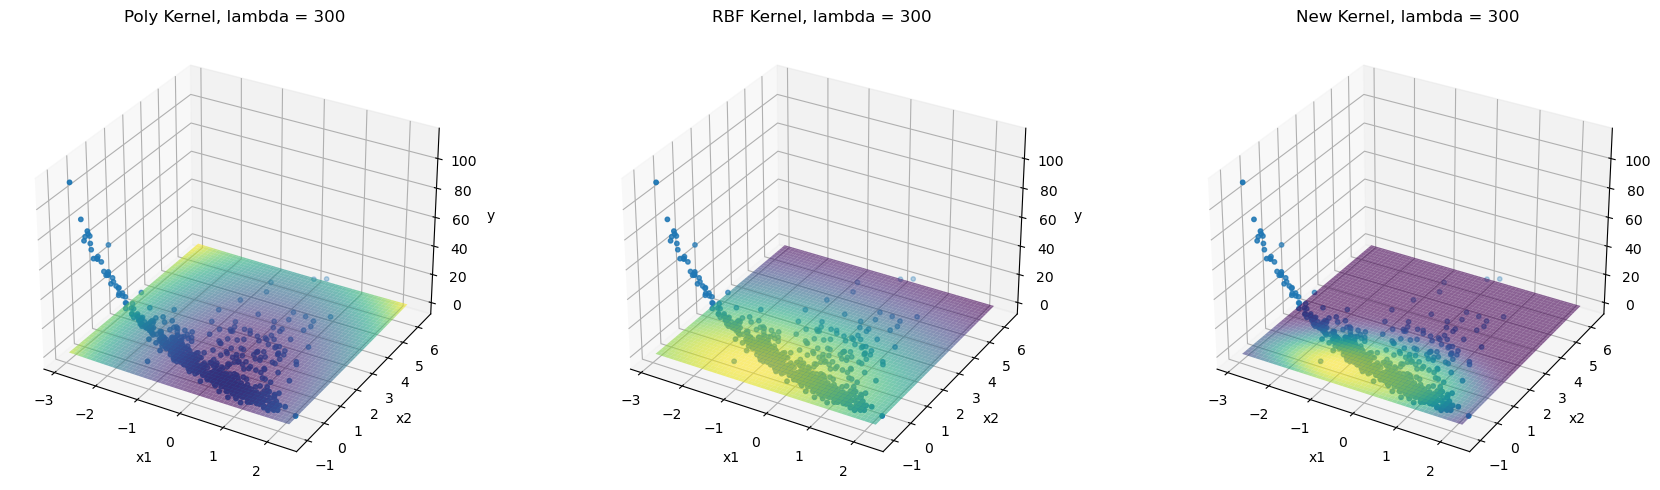

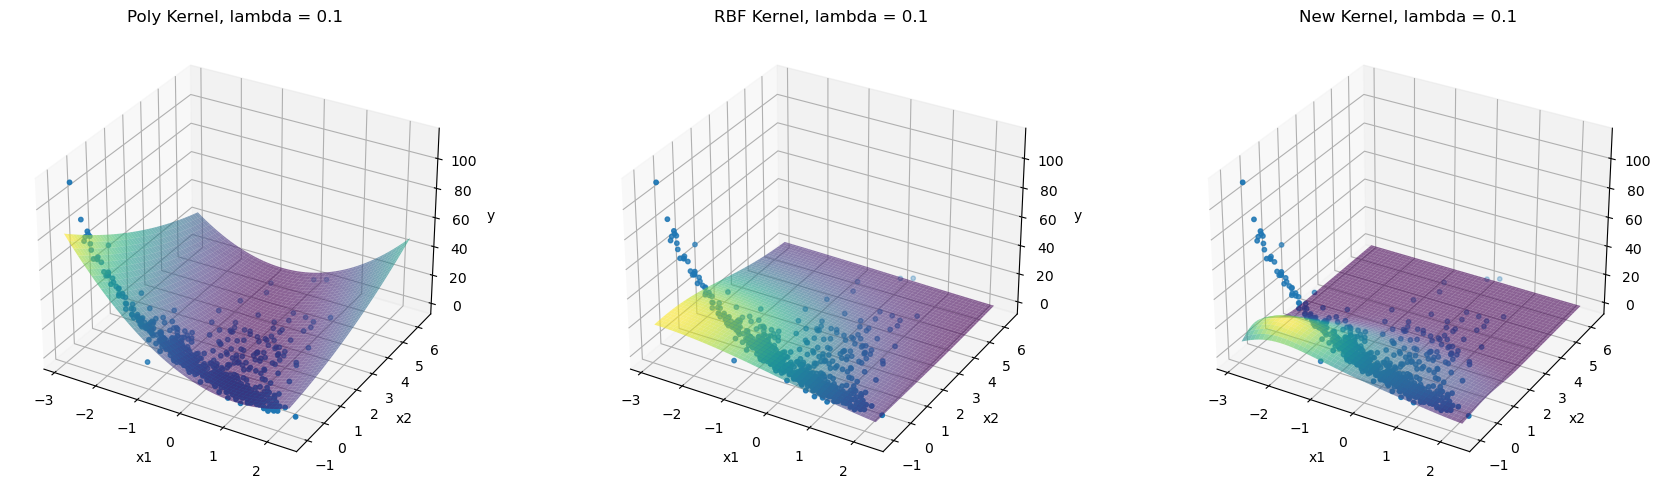

In [136]:
lam = 300

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

plot_krr(ax1, X_train_std, y_train_diam, poly_kernel, lam, f"Poly Kernel, lambda = {lam}")
plot_krr(ax2, X_train_std, y_train_diam, radial_kernel, lam, f"RBF Kernel, lambda = {lam}")
plot_krr(ax3, X_train_std, y_train_diam, new_kernel, lam, f"New Kernel, lambda = {lam}")

plt.tight_layout()
plt.show()

lam = 0.1

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

plot_krr(ax1, X_train_std, y_train_diam, poly_kernel, lam, f"Poly Kernel, lambda = {lam}")
plot_krr(ax2, X_train_std, y_train_diam, radial_kernel, lam, f"RBF Kernel, lambda = {lam}")
plot_krr(ax3, X_train_std, y_train_diam, new_kernel, lam, f"New Kernel, lambda = {lam}")

plt.tight_layout()
plt.show()


Now I want to look at the performance of a cubic kernel, since it had the best $R^2$ performance in 2.1

Polynomial Kernel R^2: 0.9817462292431357


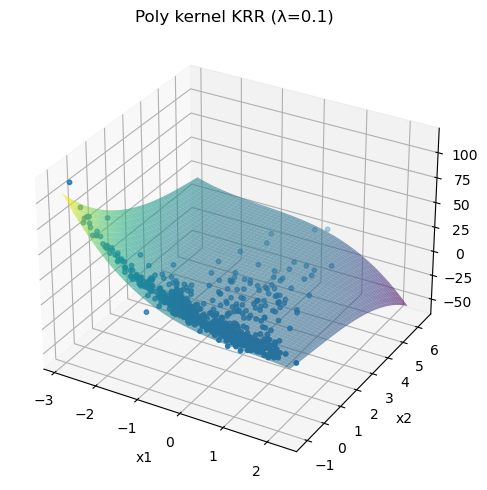

In [ ]:
kernel_performance(Gram, X_reduced, y_train_diam, 0.1)
lam = 0.1

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

plot_krr(
    ax,
    X_train_std,
    y_train_diam,
    Gram,
    lam,
    f"Poly kernel KRR (λ={lam})"
)

plt.tight_layout()
plt.show()


### Summary

Firstly, setting $\lambda$ equal to 300, makes R squared negative, implying that the performance of the model with this parameter is worse than just setting our predictions equal to the mean of the diameters. $ \lambda = 300 $ is definitely way too large, so the krr betas become 
$$ \beta_{krr} = (K + \lambda I)^{-1}y \approx (\lambda I)^{-1}y = \frac{1}{\lambda}y
$$

So for large $\lambda$ the predictions jsut shrink to almost 0. This exlpains why the surfaces of the plots are flat.

I then set $\lambda$ to 0.1 to otherwise asses the performance of KRR for different kernels. $R^2$ shows that the model performs well for the polynomial kernel (consistent with 2.1), but does a lot worse for the radial and mixed kernel: $R^2 \approx 0.4$. The plots support this -- one can clearly see that the surface (predictions) on the polynomial kernel plot follows the points (true values) a lot more closely than the surfaces on the other two plots. 

The cubic kernel yields the best $R^2$ of 0.98, however, the surface plot seems to fit the data slightly worse than the quadratic kernel.

In conclusion, this study of Kernelised Ridge Regression shows that for our data, a more conservative value of lambda (eg 0.1) and a simple quadratic kernel are the most suitable hyperparameters of the KRR model. Overall, KRR is a very good choice of model for this task, since our plots as well as $R^2$ scores clearly indicate a non-linear relationship between the predictors and the prediction.

<a name="task-3"></a>

# Task 3: Classification with the Multi-Layer Perceptron [(index)](#index-task-3)

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

Here we will set up the MLP architecture for soft multi-class classification as follows.  
The network consists of an input layer, three hidden layers with respectively
64, 64, and 32 neurons, followed by an output layer with 3 neurons
(corresponding to $Q = 3$ class probabilities).  
For all hidden layers, apply the ReLU activation function.

The network is trained on the training set by minimising the cross-entropy (CE)
loss function:

$$
CE = - \sum_{i=1}^{N^{\text{train}}} \sum_{q=0}^{Q-1} y_q^{(i)} \log p_q^{(i)} .
$$

Here, $y_q^{(i)}$ denotes the $q$-th element of the class label $y^{(i)}$ of sample
$i$ in one-hot encoding, while $p_q^{(i)}$ denotes the predicted probability for
class $q$ for sample $i$.

In one-hot encoding, the class label $0$ is expressed as
$$
y = (1, 0, 0),
$$
while the class label $1$ is expressed as
$$
y = (0, 1, 0).
$$

The predicted probabilities are obtained by applying the softmax function to the
pre-activations $a^{(N_L+1)}$ of the output units:

$$
p_q = \mathrm{softmax}\!\left(a^{(N_L+1)}\right)_q
= \frac{\exp\!\left(a_q^{(N_L+1)}\right)}
{\sum_{q'=0}^{Q-1} \exp\!\left(a_{q'}^{(N_L+1)}\right)},
$$

for $Q = 3$, where $N_L$ denotes the number of hidden layers.

In order to perform SGD we need to find the gradient of CE Loss. First let's diffirentiate $p_q$:

$$
L = -\sum_{q} y_q \log p_q
$$

$$
\frac{\partial CE}{\partial a_j}
= - \sum_q y_q \frac{\partial}{\partial a_j} \log p_q
= - \sum_q y_q \frac{1}{p_q} \frac{\partial p_q}{\partial a_j}
$$

$$
\frac{\partial p_q}{\partial a_j}
= p_q(\delta_{qj} - p_j)
$$

$$
\frac{\partial CE}{\partial a_j}
= - \sum_q y_q \frac{1}{p_q} p_q(\delta_{qj} - p_j)
= - \sum_q y_q (\delta_{qj} - p_j)
$$

$$
= - \sum_q y_q \delta_{qj} + \sum_q y_q p_j
$$

$$
= - y_j + p_j \sum_q y_q
$$

$$
= p_j - y_j, \text{since} \sum_q y_q = 1
$$

So $(\nabla_a CE)_{ij} = p_j^{(i)} - y_j^{(i)}.$

I will mostly take the code from Week 5 tutorial, with slight changes in sgd_step and sgd functions to allow user to choose a loss function, since we will use CE in 3.1 and then MSE in 3.2.

In [ ]:
# All the functions in this cell are imported from MLP notebook

def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in is the input dimension.
        W (np.ndarray): h_out x h_in array for weights matrix parameters, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = X @ W.T + b
    return a

def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.maximum(a, 0.)  ## <-- EDIT THIS LINE
    return h

def identity(x):
    return x

## EDIT THIS FUNCTION
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    return (a > 0).astype(float)

var0 = 2. / (64 + 8)
W0 = rng.normal(size=(64, 8)) * np.sqrt(var0)
b0 = np.zeros(64)

var1 = 2. / (64 + 64)
W1 = rng.normal(size=(64, 64)) * np.sqrt(var1)
b1 = np.zeros(64)

var2 = 2. / (32 + 64)
W2 = rng.normal(size=(32, 64)) * np.sqrt(var2)
b2 = np.zeros(64)

var3 = 2. / (3 + 32)
W3 = rng.normal(size=(3, 32)) * np.sqrt(var3)
b3 = np.zeros(1)

def mlp_3layers(X):
    """MLP with 3 hidden layers and ReLU activation

    Parameters:
        X: K x 8 array of inputs

    Returns:
        y:  K x 1 output array
    """
    if X.ndim == 1:
        # If one example passed, add a dummy dimension for the batch.
        X = X.reshape(1, -1)

    # compose 3-layer MLP
    h = X
    a = dense(h, W0, b0)
    h = relu_activation(a)

    a = dense(h, W1, b1)
    h = relu_activation(a)

    a = dense(h, W2, b2)
    h = relu_activation(a)
    y = dense(h, W3, b3)

    return y

# A lookup table for activation functions by their names.
activation_table = {
    "relu": relu_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}


In [ ]:
class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers (including input and output)."""
        return len(self.layers) + 1 if len(self.layers) > 0 else 0

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The input dimension of the layer.
            out_dim (int): The output dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            # hint: use self.rng.normal()
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)), ## <-- SOLUTION
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), ## <-- SOLUTION
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"]) ## <-- SOLUTION
            activation = activation_table[self.layers[k]["activation"]] ## <-- SOLUTION
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) ## <-- SOLUTION
        # predicted target is output of last layer
        return y_hat, forward_pass

In [ ]:
def softmax(a):
    """
    Numerically stable softmax.

    Parameters:
    a : np.ndarray, shape (N, 3)
        Logits (pre-activations).

    Returns:
    p : np.ndarray, shape (N, 3)
        Softmax probabilities.
    """
    a = np.asarray(a, dtype=float)
    exp_a = np.exp(a)
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    """
    Cross-entropy loss.

    Parameters:
    y_true : np.ndarray, shape (N, 3)
        One-hot encoded true labels.
    p_pred : np.ndarray, shape (N, 3)
        Predicted class probabilities.
    eps : float
        Small constant for numerical stability.

    Returns:
    loss : float
        Cross-entropy loss (mean over samples).
    """
    loss = -np.sum(y_true * np.log(softmax(y_pred)), axis=1)
    return np.sum(loss)

def ce_grad(y_true, y_pred):
    return softmax(y_pred) - y_true

def y_hot(y, Q=3):
    Q = y.shape[1]
    return np.eye(Q)[y.astype(int)]

In [ ]:
def mse_loss(y_true, y_pred):
    """Compute MSE-loss

    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )

    Returns:
        loss (float): MSE-loss
    """
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    # Compute MSE loss
    loss = np.mean((y_true - y_pred)**2, keepdims=True) ## <-- SOLUTION
    return loss

def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    # Compute gradient of MSE loss
    grad = 2.0 * (y_pred - y_true) / y_true.size ## <-- SOLUTION
    return grad

# THis dictionary will be used to choose the loss function for sgd
loss_grad_dict = {"ce": [cross_entropy_loss, ce_grad], "mse": [mse_loss, grad_mse_loss]}

In [ ]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        gradients (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric in the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    gradients = []

    # Initialise delta.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):   # zip iterates through pairs of layers and forward_pass
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."

        # Gradients are average gradients over batch
        gradients.append({"W" : (delta.T @ h) / h.shape[0], # <-- SOLUTION
                          "b" : delta.mean(axis=0)}) # <-- SOLUTION

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)]) # <-- SOLUTION.


    # Return now ordered list matching the layers.
    gradients = list(reversed(gradients))
    return gradients


In [ ]:
def sgd_step(X, y, mlp, loss_grad, learning_rate = 1e-3):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, p).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        updated_layers (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = loss_grad(y, y_hat) ## <-- SOLUTION

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)  ## <-- SOLUTION.

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"] ## <-- SOLUTION.
        b = layer["b"] - learning_rate * grad["b"] ## <-- SOLUTION.
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [ ]:
def sgd(X_train, y_train, X_test, y_test, mlp, loss_function_str, learning_rate = 1e-3,
        n_epochs=10, minibatchsize=1, seed=42, print_epochs=True):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (N^{training}, p).
        y_train (np.ndarray): The training data ground-truth, with shape (N^{training}, 1).
        X_test (np.ndarray): The testing data features, with shape (N^{test}, p).
        y_test (np.ndarray): The testing data ground-truth, with shape (N^{test}, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.

    Returns:
        mlp (MLP): MLP object encapuslating the trained MLP model.
        losses_train (np.ndarray): Train losses over epochs.
        losses_tset (np.ndarray): Test losses over epochs.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    for i in range(n_epochs):

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, loss_grad_dict[loss_function_str][1], learning_rate) ## <-- SOLUTION.

            # update weights and biases of MLP
            mlp.layers = updated_layers ## <-- SOLUTION.
        
        loss_function = loss_grad_dict[loss_function_str][0]

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        loss_train = loss_function(y_train, y_hat_train).squeeze()
        losses_train.append(loss_train)
        y_hat_test, _ = mlp.predict(X_test)
        loss_test = loss_function(y_test, y_hat_test).squeeze()
        losses_test.append(loss_test)

        if (i==0) or ((i+1)%(n_epochs//10)==0) and print_epochs:
          print(
              f'Epoch {i+1}/{n_epochs}: Training loss: {loss_train}, testing loss: {loss_test}'
               )

    return mlp, losses_train, losses_test


In [ ]:
# Training MLP
mlp = MLP(seed=2)
mlp.add_layer(X_train_std.shape[1], 64, "identity")
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 32, "relu")
mlp.add_layer(32, 3, "relu")
y_train_oh = np.eye(3)[y_train_class_int]
y_test_oh  = np.eye(3)[y_test_class_int]
mlp, losses_train, losses_test = sgd(X_train_std, y_train_oh, X_test_std, y_test_oh, mlp, "ce", learning_rate = 0.04,
        n_epochs=500, minibatchsize=64, seed=42)


Epoch 1/500: Training loss: 630.2823132461401, testing loss: 157.31491917060015
Epoch 50/500: Training loss: 92.48927436991525, testing loss: 32.133818816966844
Epoch 100/500: Training loss: 47.812388757323006, testing loss: 21.654584833675976
Epoch 150/500: Training loss: 30.58920943072172, testing loss: 19.38555632131796
Epoch 200/500: Training loss: 20.423915442967164, testing loss: 15.956793122735757
Epoch 250/500: Training loss: 14.203520877671412, testing loss: 14.89246546223722
Epoch 300/500: Training loss: 12.90051324648493, testing loss: 15.866016848017642
Epoch 350/500: Training loss: 7.504083731355772, testing loss: 16.30358503325245
Epoch 400/500: Training loss: 5.896071808929715, testing loss: 14.297114142694927
Epoch 450/500: Training loss: 11.175174956784833, testing loss: 24.089560582728407
Epoch 500/500: Training loss: 28.737626750985363, testing loss: 21.290849710639574


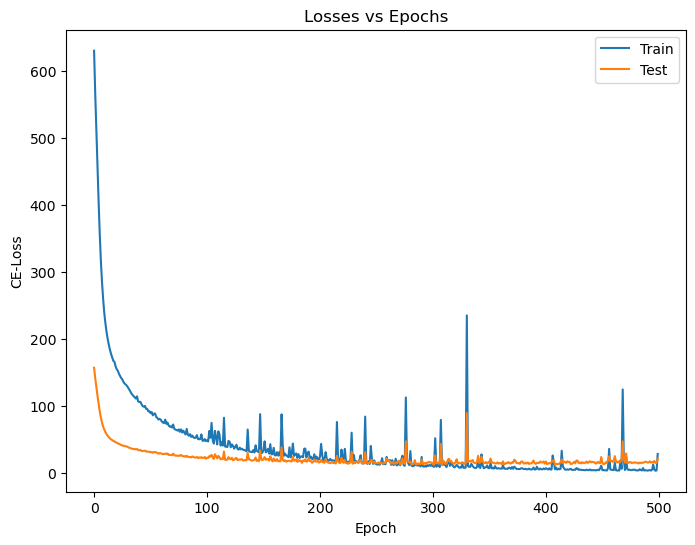

In [ ]:
# plot training progress
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(len(losses_train)),losses_train, label="Train")
ax.plot(np.arange(len(losses_test)),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "CE-Loss")
ax.legend()
plt.show()

The plot indicates that CE-loss is decreasing towards 0 for both test and train data, meaning that the model is learning.

The test loss is below the train loss for the first half of the training horison, and after that it only gets ever so slightly higher than the train loss, indicating that the model is not overfitted (there isn't a huge difference between train and test loss).

Now let's look at the model's accuracy:

In [ ]:
def accuracy(logit_pred, oh_true, classes):
    """
    Compute and print overall and per-class classification accuracy.

    Parameters:
        y_pred (np.array): Predicted logits of length N.
        y_true (np.array): True class labels of length N (one hot).
        classes (list): List of class names corresponding to class indices.

    Returns:
        None. Prints overall accuracy and per-class accuracies.
    """
    # Convert to binary
    p_pred = softmax(logit_pred)
    y_true = np.argmax(oh_true, axis=1)
    y_pred = np.argmax(p_pred, axis=1)

    # Overall accuracy
    acc = np.mean(y_pred == y_true)
    # Initiate a dict for class accuracies
    class_acc = {}
    # Loop thru classes computing accuracy
    for c in range(len(classes)):
        # Binary mask of when prediction is correct
        mask = (y_true == c)

        # Accuracy is defined as ratio of correct predictions
        # 
        class_acc[classes[c]] = np.mean(y_pred[mask] == y_true[mask])
    print(f"Overall accuracy: {acc}")
    print(class_acc)
    return class_acc

classes = ["MBA", "OMB", "TJN"]
pred, _ = mlp.predict(X_test_std)

accuracy(pred, y_test_oh, classes)


Overall accuracy: 0.9375
{'MBA': 0.9622641509433962, 'OMB': 0.8596491228070176, 'TJN': 1.0}


In [ ]:
from collections import Counter
print(Counter(y_test_class))
    

Counter({'OMB': 57, 'MBA': 53, 'TJN': 50})


The overall accuracy of 0.94 is a good results which means that 94% of asteroids in the test data were classified correctly.

Interestingly, the accuracy of predicting the TJN class is 100% which could happen for 2 main reasons: either it is very distinct, or it is encountered infrequently in the test data and we jsut got lucky. But counting the classes in the test dataset shows that they are well balanced, which means the model just does a good job with TJN. MBA is also extremely high, while OMB is the weakest class with a significantly lower accuracy.

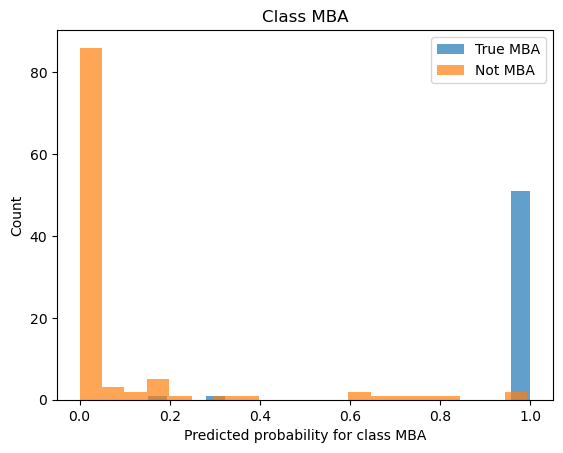

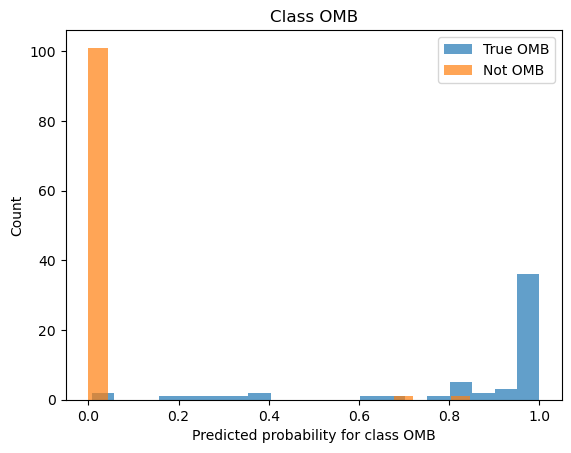

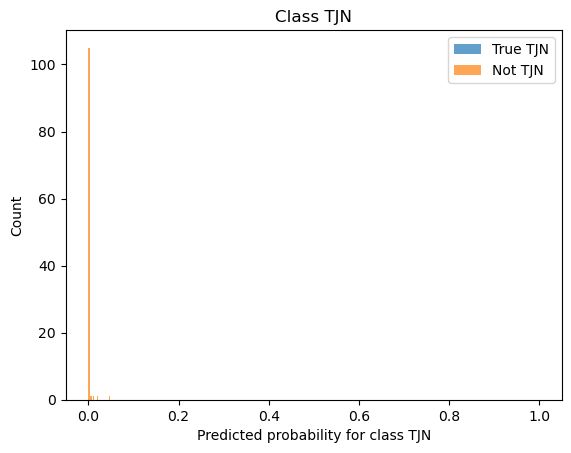

In [ ]:
# Histograms
probs = softmax(pred)

# Loop over classes
for q, class_name in enumerate(classes):

    # Mask of test samples whose true class is q
    q_idx = (y_test_class == class_name)
    # True clas is not q
    not_q_idx = (y_test_class != class_name)

    # Predicted probabilities for class q
    true_probs = probs[q_idx, q]
    other_probs = probs[not_q_idx, q]

    # plotting example
    plt.figure()
    plt.hist(true_probs, bins=20, alpha=0.7, label=f"True {class_name}")
    plt.hist(other_probs, bins=20, alpha=0.7, label=f"Not {class_name}")
    plt.xlabel(f"Predicted probability for class {class_name}")
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Class {class_name}")
    plt.show()

The historgams again show that the model detects TJN impeccably. The MBA histograms shows that a significant number of non-MBA asteroids were falsly identified as MBA. For OMB the false positive rate is much smaller, but it is still present. Looking at the histograms and at the per class accuracies, it looks like the lower OMB accuracy is caused by the model falsely identifying it as MBA.

The fact that overwhelming majority of the probabilities are essentially 0 or 1 is a good sign meaning our model is decisive.

<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)

### Gradient Boosting
To improve performance at discriminating asteroids’ classes, we implement gradient boosting with MLPs (GDMLP).
The strong model of the GBMLP is given by a soft multi-class MLP classifier which is trained to minimise the
cross-entropy (CE) loss (Equation~4), where the predicted class probabilities are given by $ p_q = \mathrm{softmax}(a)_q $


Let
$$
a = (a_0, a_1, a_2)
$$
denote the strong model’s predictions, which are updated iteratively through the weak models.
We initialise the strong model’s predictions using a \emph{warm start}, setting $a$ equal to the values of $a^{(N_L+1)}$ output by the MLP trained in 3.1.

Each weak model is an MLP with the following network architecture: an input layer, three hidden layers with
$32$, $32$, and $16$ hidden neurons respectively, followed by an output layer with $3$ neurons.
The first two hidden layers apply the ReLU activation function, while the last hidden layer applies the identity activation function. Each weak model is trained by minimising a mean squared error (MSE) loss.

We train the GBMLP using $4$ weak models and a shrinkage hyperparameter set to $\nu = 2$, using mini-batch stochastic gradient descent with mini-batch size $32$, $1000$ training epochs, and a constant learning rate of $0.05$.
The performance of the GBMLP is evaluated on the test set, and the class-specific accuracy is reported after each boosting iteration. The results are then discussed.

Since gradient boosting fits weak learners to the negative gradient of the loss, and the strong model minimises cross-entropy, each weak MLP is trained to predict y−p, where p are the current softmax probabilities.



In [ ]:
nu = 2
a, _ = mlp.predict(X_train_std)
a_test, _ = mlp.predict(X_test_std)
p = X_train_std.shape[1]
for i in range(4):
    # Create weak mlp model
    weak_mlp = MLP(seed=2)
    weak_mlp.add_layer(p, 32, "identity")
    weak_mlp.add_layer(32,32, "relu")
    weak_mlp.add_layer(32, 16, "relu")
    weak_mlp.add_layer(16, 3, "identity")

    # COmpute residuals (weak mlp's target)
    r_train = y_train_oh - softmax(a)
    r_test = y_test_oh - softmax(a_test)
    # Train weak mlp
    weak_mlp, losses_train, losses_test = sgd(X_train_std, r_train, X_test_std, r_test, weak_mlp, "mse", learning_rate = 0.05,
        n_epochs=1000, minibatchsize=32, seed=42, print_epochs = False)
    
    # Update a
    weak_train = weak_mlp.predict(X_train_std)[0]

    a += nu * weak_train

    # Compute class-specific accuracy
    weak_test = weak_mlp.predict(X_test_std)[0]
    a_test += nu * weak_test
    p_test = softmax(a_test)
    y_true = np.argmax(y_test_oh, axis=1)
    y_pred = np.argmax(p_test, axis=1)

    # per-class accuracy
    acc = np.mean(y_pred == y_true)
    class_acc = {}
    print(f"The per-class accuracy of weak model {i} is:")
    for c in range(len(classes)):
        mask = (y_true == c)
        class_acc[classes[c]] = np.mean(y_pred[mask] == y_true[mask])
    print(f"Overall accuracy: {acc}")
    print(class_acc)
    print("-----------------")



Epoch 1/1000: Training loss: 0.05439759782006178, testing loss: 0.06105825799384922
The per-class accuracy of weak model 0 is:
Overall accuracy: 0.9375
{'MBA': 0.9622641509433962, 'OMB': 0.8596491228070176, 'TJN': 1.0}
-----------------
Epoch 1/1000: Training loss: 0.05240020586044785, testing loss: 0.059834077109158515
The per-class accuracy of weak model 1 is:
Overall accuracy: 0.94375
{'MBA': 0.9622641509433962, 'OMB': 0.8771929824561403, 'TJN': 1.0}
-----------------
Epoch 1/1000: Training loss: 0.05087401673705479, testing loss: 0.058904121270956365
The per-class accuracy of weak model 2 is:
Overall accuracy: 0.95
{'MBA': 0.9622641509433962, 'OMB': 0.8947368421052632, 'TJN': 1.0}
-----------------
Epoch 1/1000: Training loss: 0.04972244906648163, testing loss: 0.05819971484500231
The per-class accuracy of weak model 3 is:
Overall accuracy: 0.95625
{'MBA': 0.9622641509433962, 'OMB': 0.9122807017543859, 'TJN': 1.0}
-----------------


Gradient boosting increased the overall accuracy from 0.9375 to 0.95625. In particular, it increased the accuracy of predicting the OMB class, the MBA and TJN accuracies stayed the same (TJN was already 1, and MBA's 0.962 acuracy is also extremely high), so Gradient boosting addressed the weak spot of regular mlp.